In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import time
# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import my_unet

Using TensorFlow backend.


In [2]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48627
Train set size: 30000
Validation set size: 15000
Test set size: 3627


In [18]:
H,W = 256, 256
norm = 255.0
compr_range = (16,21)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.uint8)


# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1)

    
# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2)
    
val_unc /= norm
val_compr /= norm

In [19]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_data_augmentation_imagenet_compress_16_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam()
model = my_unet()
model.compile(loss = "mse",optimizer=opt)

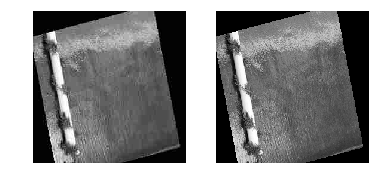

In [20]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=60,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval = 0)

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2)
        yield(batch_comp/255.0, batch_unc/255.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)


# sample data augmentation
for ii in combined:
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [21]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
3750/3750 [==============================] - 365s 97ms/step - loss: 7.1097e-04 - val_loss: 0.0014
Epoch 2/30
3750/3750 [==============================] - 365s 97ms/step - loss: 6.5377e-04 - val_loss: 0.0014
Epoch 3/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.4152e-04 - val_loss: 0.0014
Epoch 4/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.3489e-04 - val_loss: 0.0014
Epoch 5/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.3000e-04 - val_loss: 0.0014
Epoch 6/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.2717e-04 - val_loss: 0.0014
Epoch 7/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.2434e-04 - val_loss: 0.0013
Epoch 8/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.2169e-04 - val_loss: 0.0014
Epoch 9/30
3750/3750 [==============================] - 364s 97ms/step - loss: 6.2123e-04 - val_loss: 0.0013
Epoch 10/30
3750/37

In [22]:
# Test set
test_unc = np.zeros((len(test_images),H,W,1),dtype = np.float32)
test_compr = test_unc.copy()
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    test_compr[ii,:,:,0] = np.array(im2)
    
test_unc /= norm
test_compr /= norm

In [23]:
pred = model.predict(test_compr)

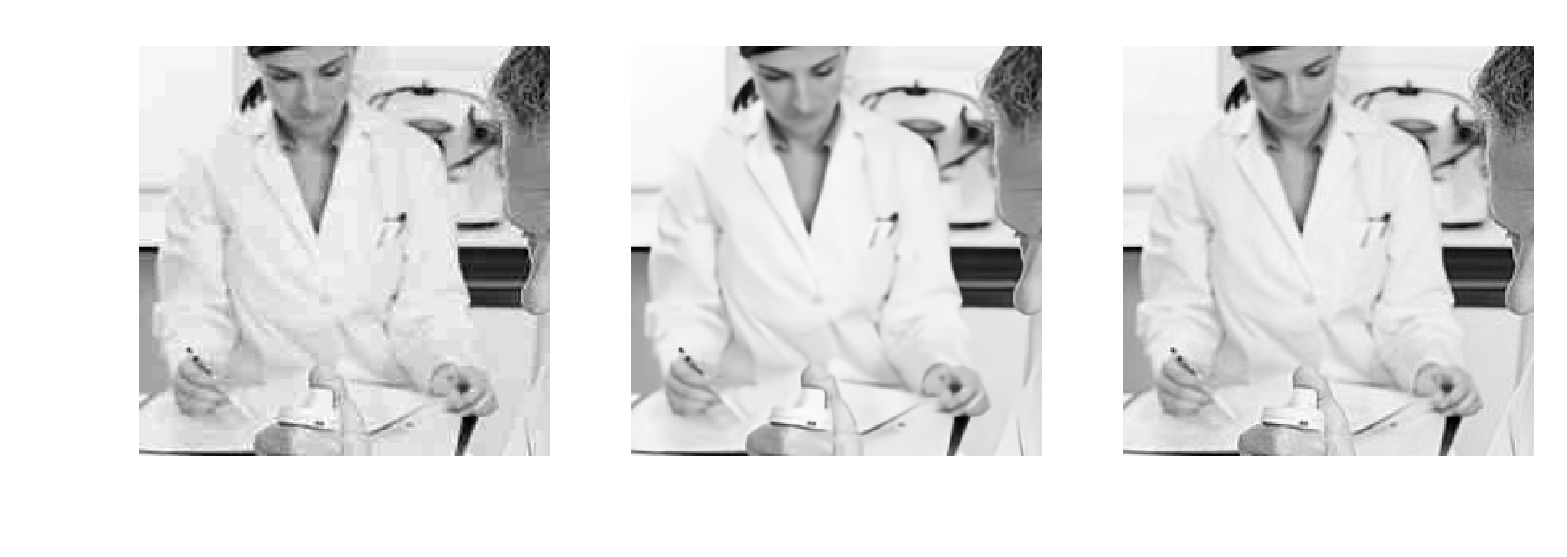

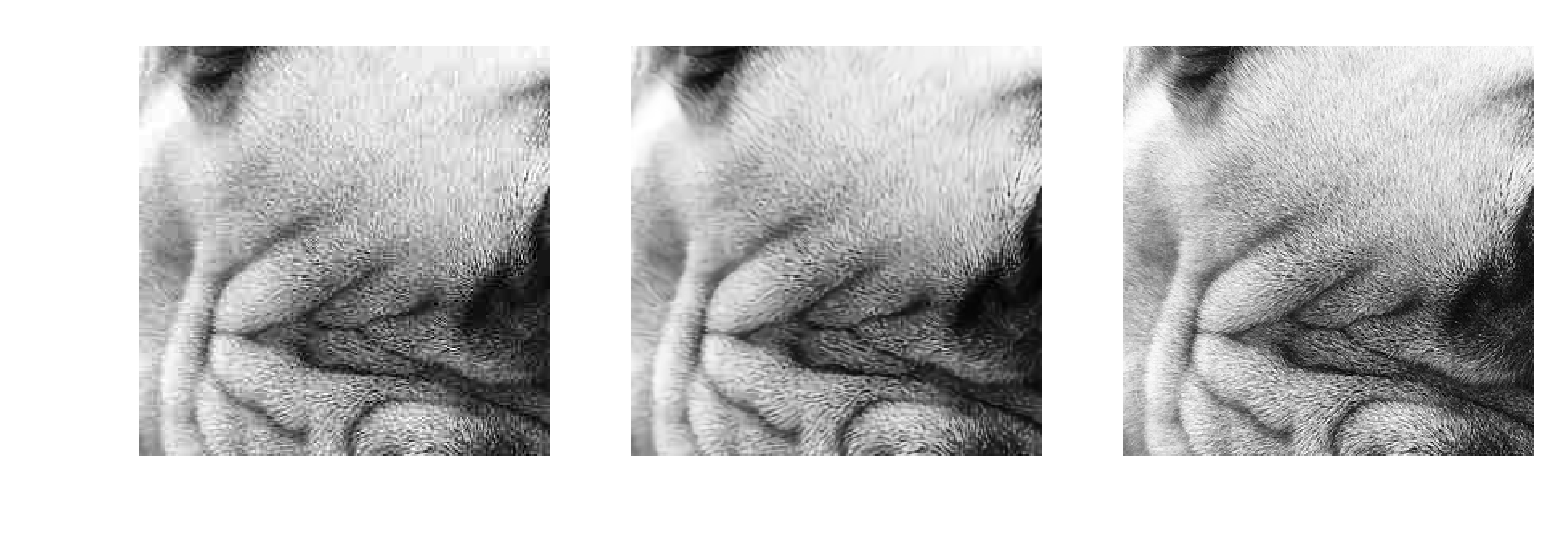

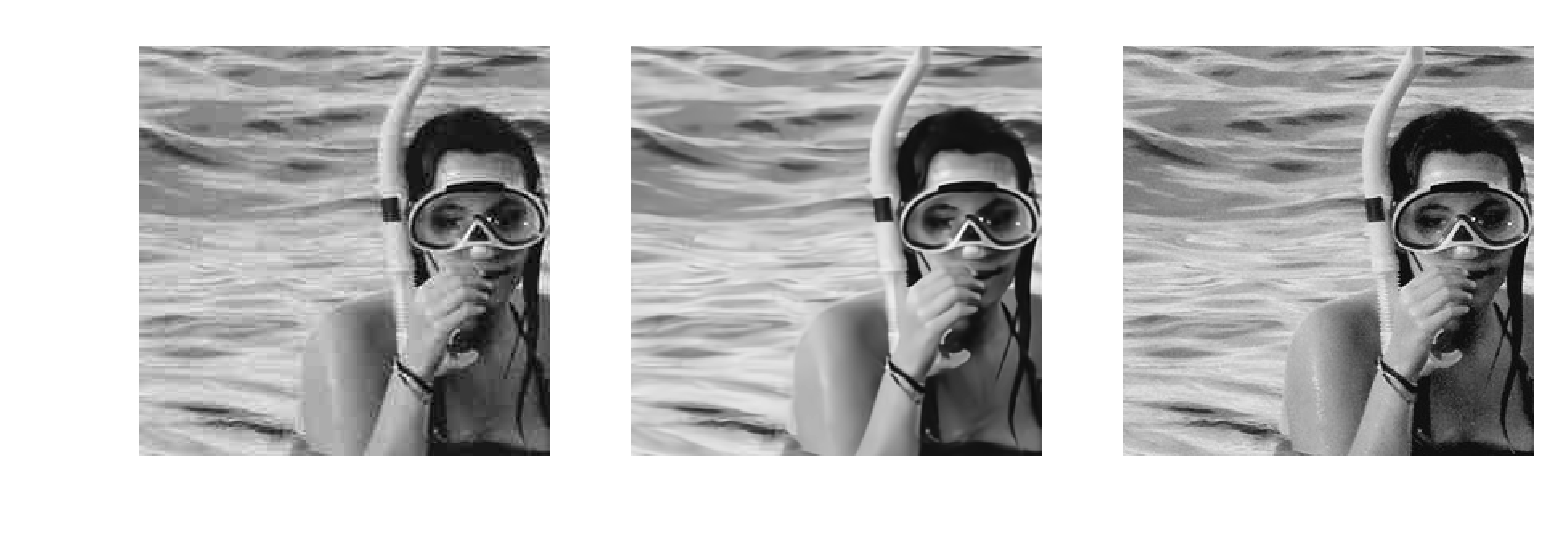

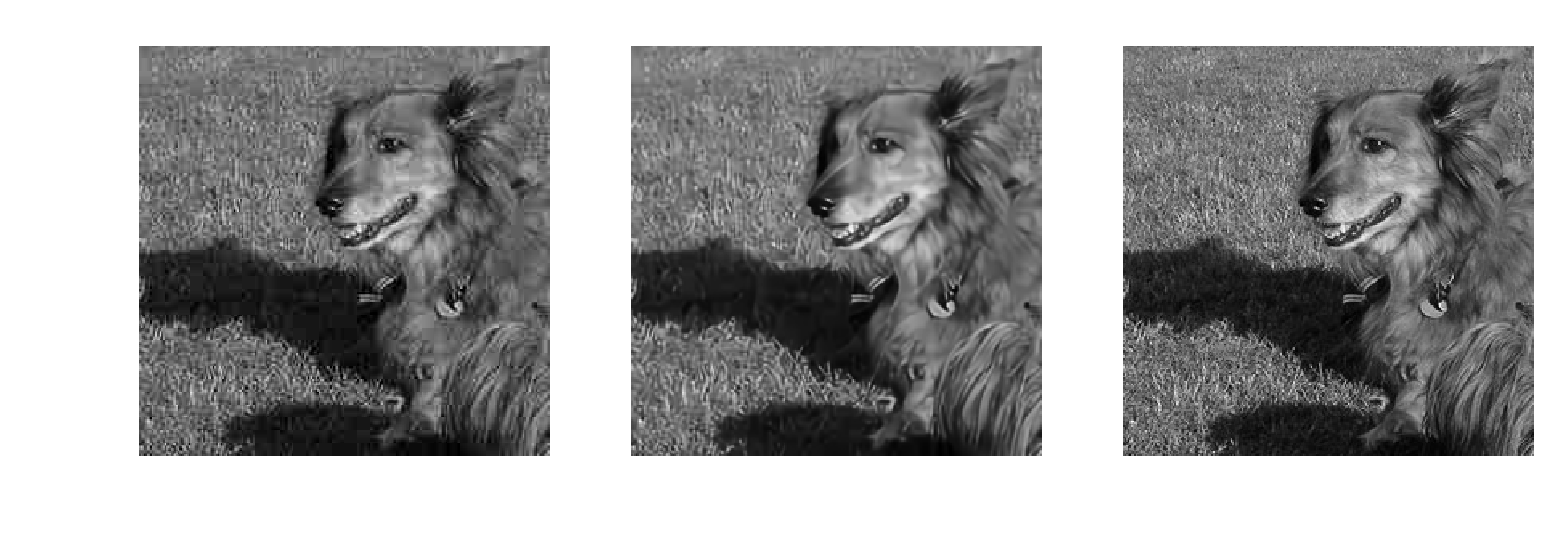

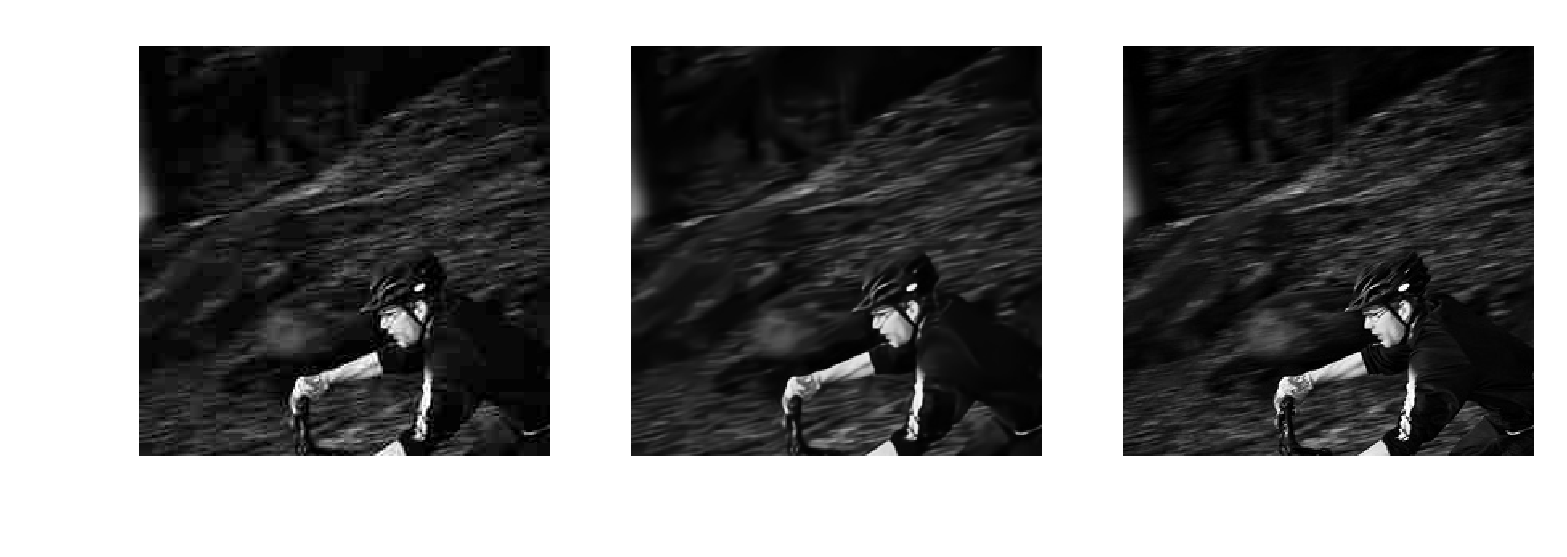

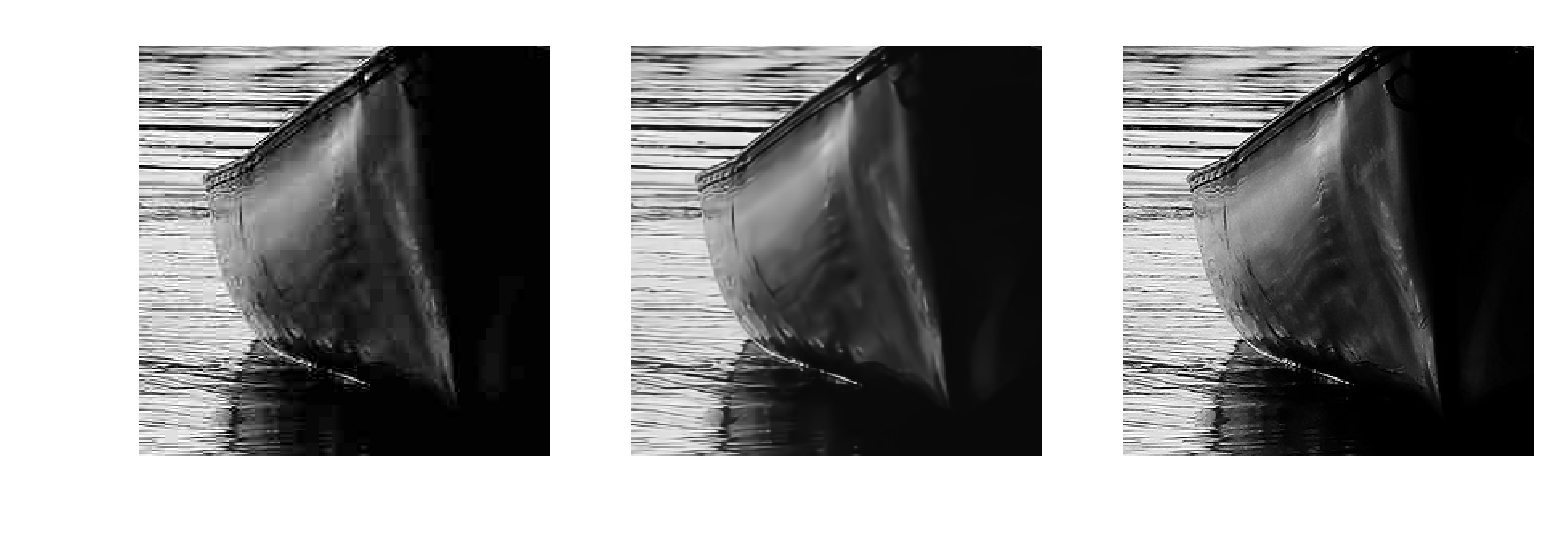

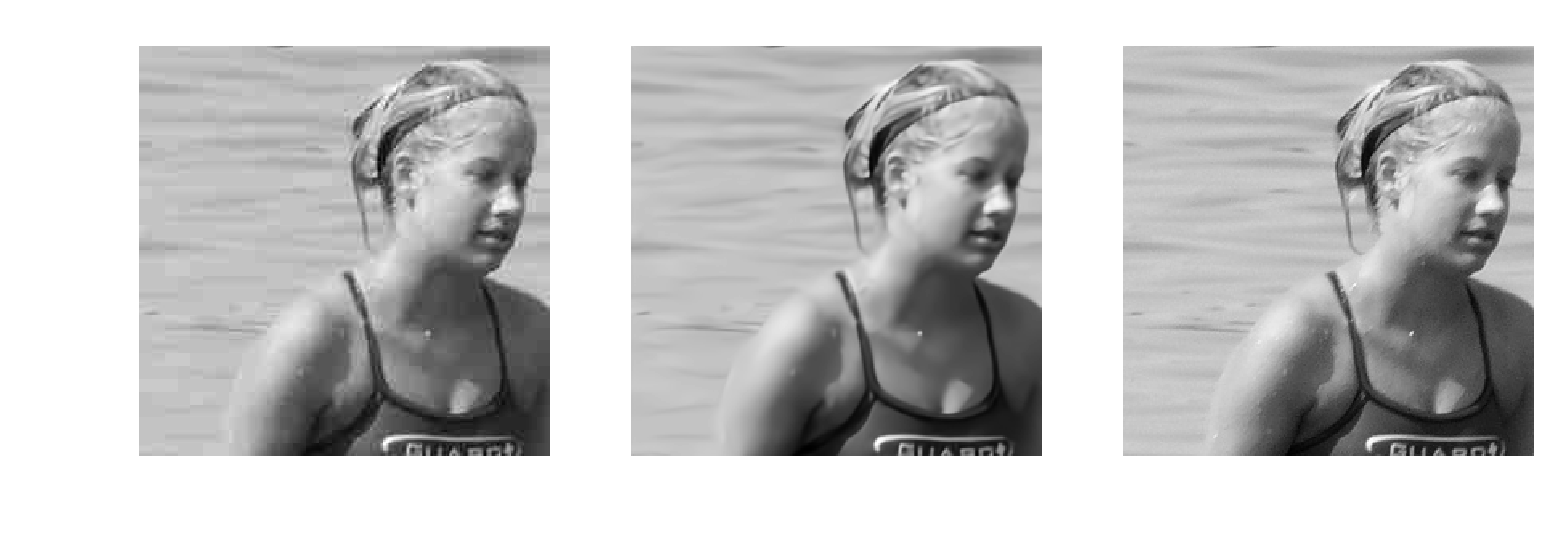

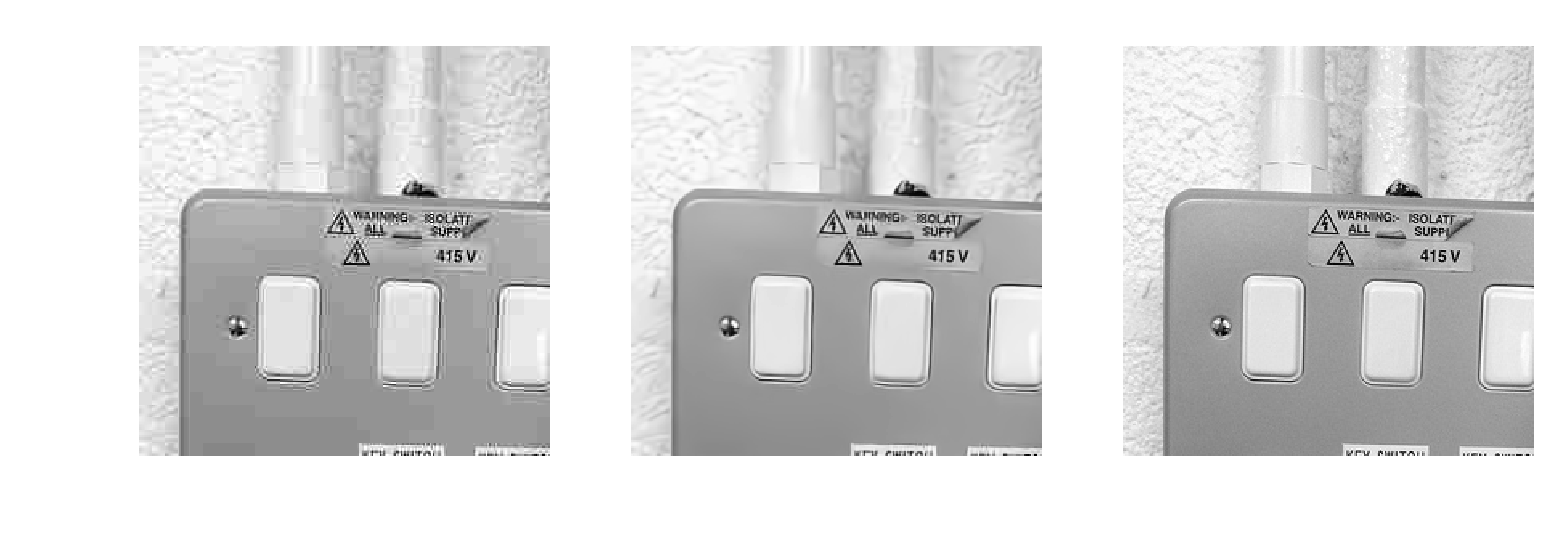

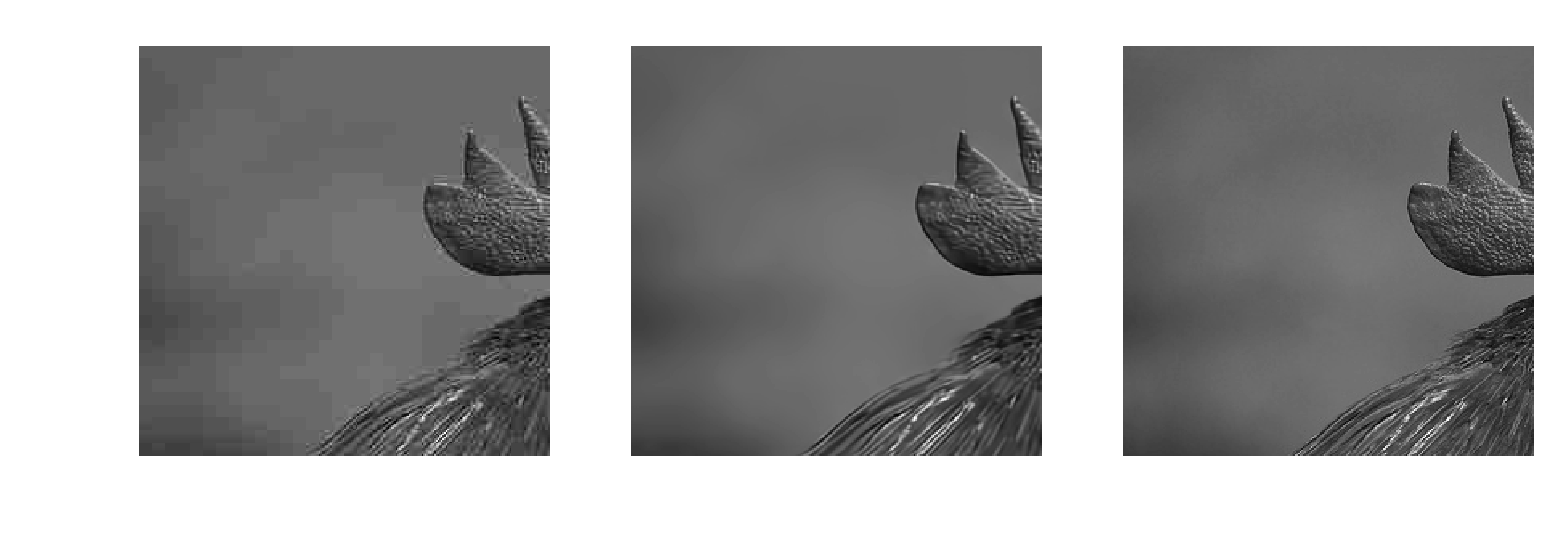

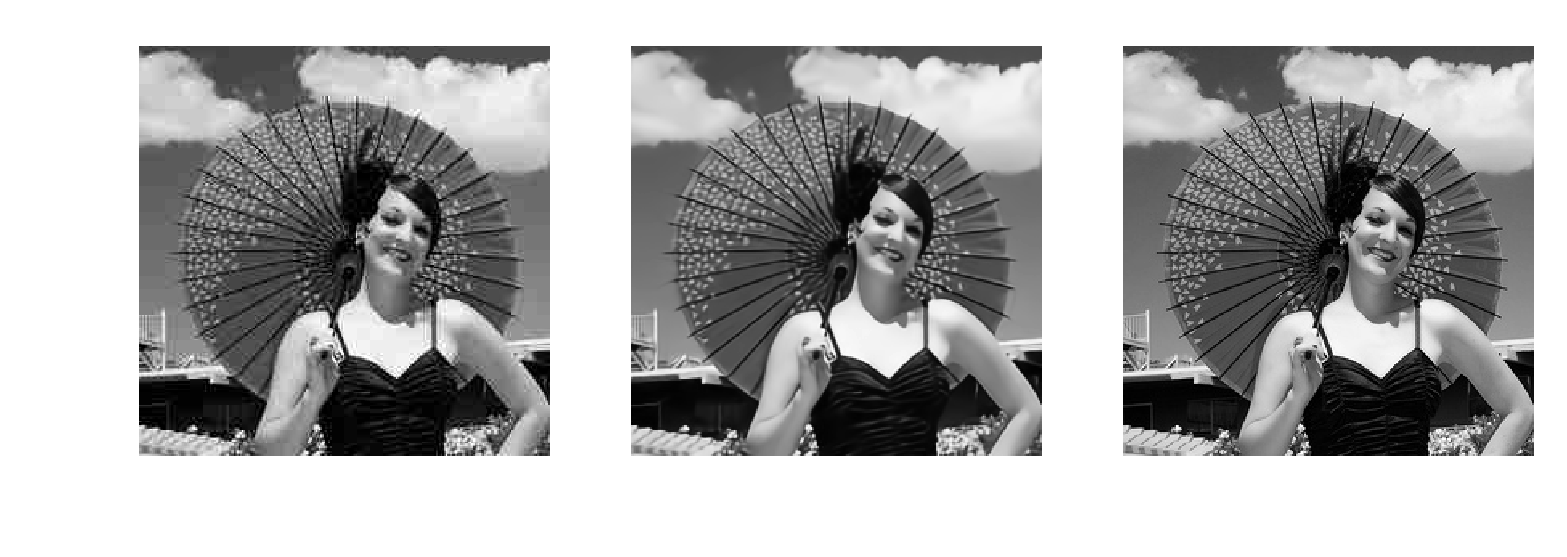

In [24]:
for ii in np.random.choice(np.arange(0,test_unc.shape[0], dtype=int), 10):
    ii = int(ii)
    plt.figure(dpi = 300)
    plt.subplot(131)
    plt.imshow(test_compr[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(pred[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(test_unc[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.show()